In [ ]:
pip install pyfacer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.8 MB/s eta 0:00:00


In [ ]:
import torch
import facer

/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


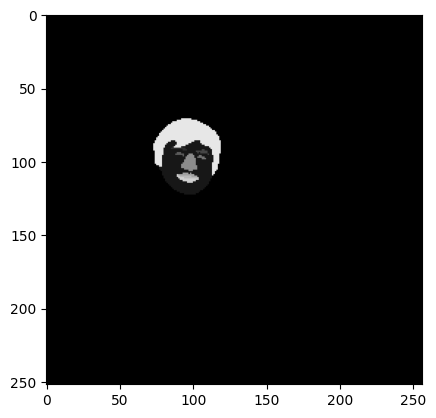

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

image = facer.hwc2bchw(facer.read_hwc('/content/khoadd.jpeg')).to(device=device)  # image: 1 x 3 x h x w

face_detector = facer.face_detector('retinaface/mobilenet', device=device)
with torch.inference_mode():
    faces = face_detector(image)

face_parser = facer.face_parser('farl/lapa/448', device=device) # optional "farl/celebm/448"

with torch.inference_mode():
    faces = face_parser(image, faces)

seg_logits = faces['seg']['logits']
seg_probs = seg_logits.softmax(dim=1)  # nfaces x nclasses x h x w
n_classes = seg_probs.size(1)
vis_seg_probs = seg_probs.argmax(dim=1).float()/n_classes*255
vis_img = vis_seg_probs.sum(0, keepdim=True)
facer.show_bhw(vis_img)

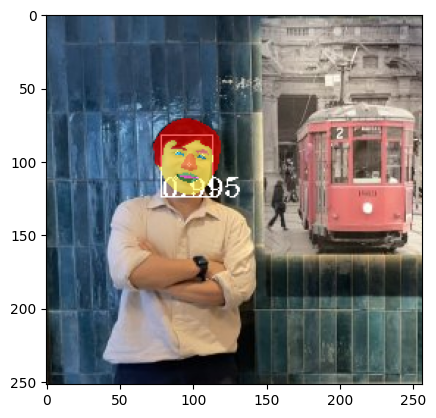

In [ ]:
facer.show_bchw(facer.draw_bchw(image, faces))

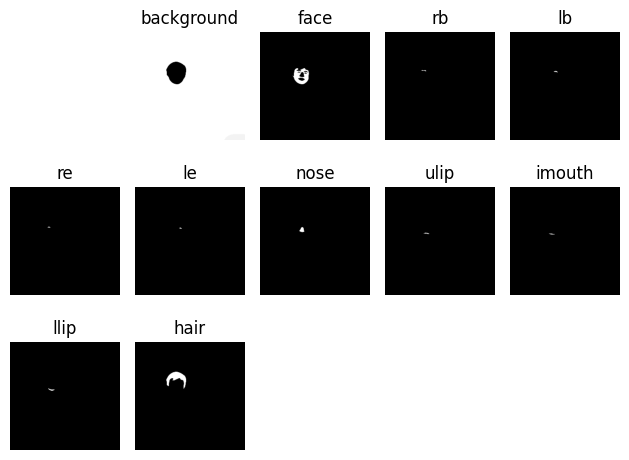

In [ ]:
import torch
import matplotlib.pyplot as plt

# Extract the segmentation logits from the faces dictionary
seg_logits = faces['seg']['logits']
seg_probs = seg_logits.softmax(dim=1)  # nfaces x nclasses x h x w

# Get the number of classes and the label names
n_classes = seg_probs.size(1)
conf_name = face_parser.conf_name  # e.g., 'lapa/448' or 'celebm/448'
label_names = facer.face_parsing.farl.pretrain_settings[conf_name]['label_names']



# Now proceed with the rest of the code
seg_logits = faces['seg']['logits']
seg_probs = seg_logits.softmax(dim=1)  # nfaces x nclasses x h x w

# Get the number of classes
n_classes = seg_probs.size(1)
n_images = len(label_names)
cols = 5  # Number of columns in the grid (adjust as needed)
rows = (n_images + cols - 1) // cols

for i, label in enumerate(label_names):
    # Get the segmentation mask for the class
    seg_mask = seg_probs[:, i, :, :].sum(0, keepdim=True)  # Sum over faces
    seg_mask = seg_mask.float() / n_classes * 255  # Normalize for display

    # Show the mask using facer.show_bhw
    # facer.show_bhw(seg_mask)

    seg_mask_np = seg_mask.squeeze().cpu().numpy().astype('uint8')
    plt.subplot(rows, cols, i + 2)
    plt.imshow(seg_mask_np, cmap='gray')
    plt.title(f'{label}')
    plt.axis('off')

plt.tight_layout()
plt.show()

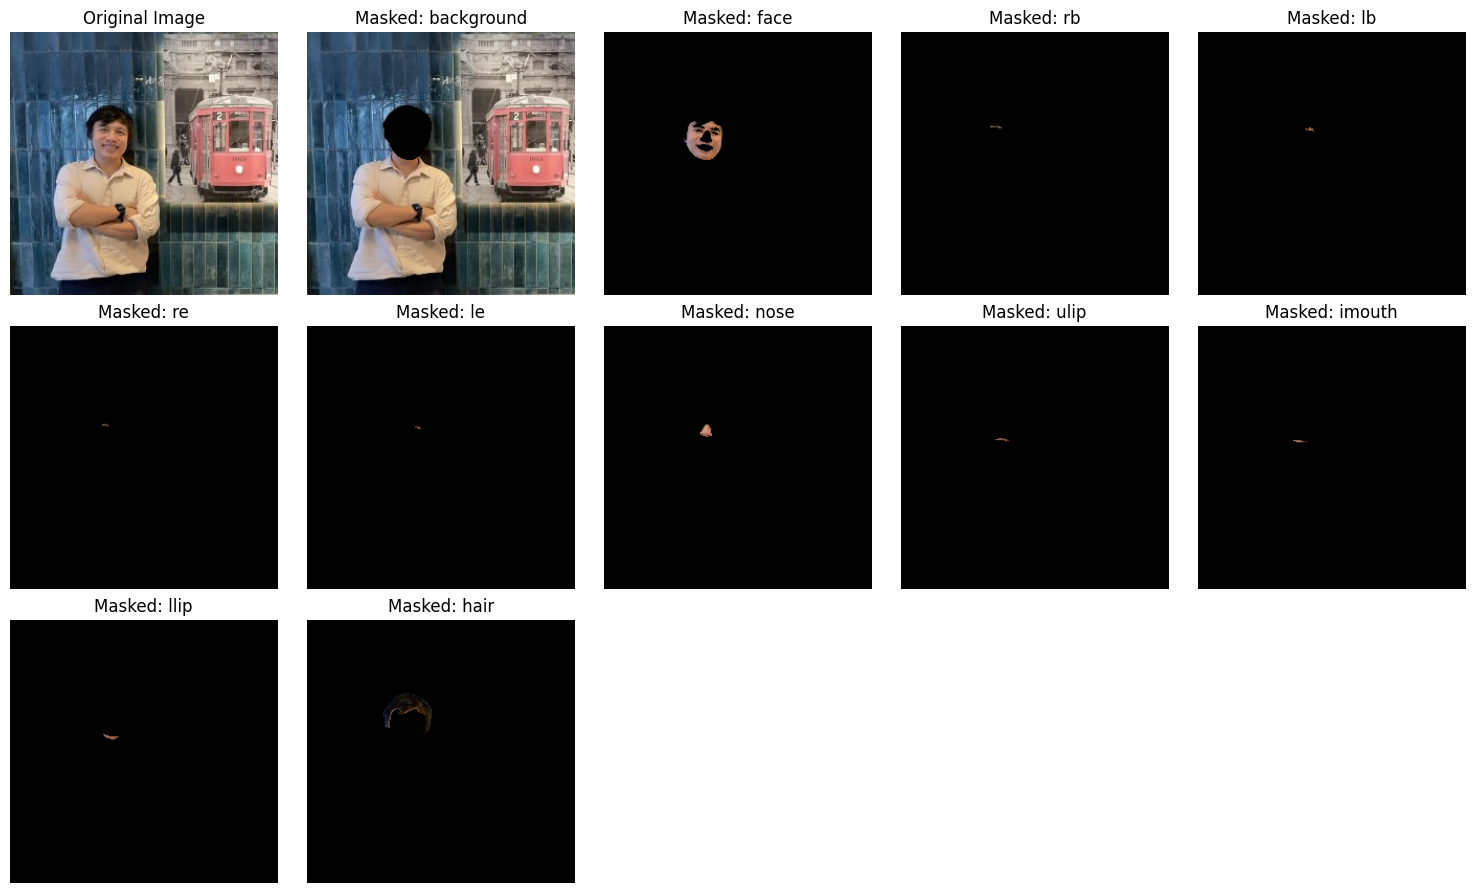

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Function to create a binary mask
def create_binary_mask(seg_probs, class_idx, threshold=0.5):
    # Select the class of interest and create a binary mask
    seg_mask = seg_probs[:, class_idx, :, :]
    binary_mask = (seg_mask > threshold).float()  # Apply threshold to get binary mask
    return binary_mask

def apply_mask_to_image(image, binary_mask):
    # Ensure the binary mask is of the same shape as the image
    # Reshape the binary mask to match the image shape
    # Select the first face (index 0) and expand to match the color channels
    binary_mask = binary_mask[0].unsqueeze(0).expand(image.shape[1], -1, -1)
    binary_mask = binary_mask.unsqueeze(0)  # Add the batch dimension back

    masked_image = image * binary_mask
    return masked_image

# Extract the segmentation probabilities
seg_logits = faces['seg']['logits']
seg_probs = seg_logits.softmax(dim=1)  # nfaces x nclasses x h x w

# Get the number of classes and labels from pretrain_settings
conf_name = face_parser.conf_name  # e.g., 'lapa/448' or 'celebm/448'
label_names = facer.face_parsing.farl.pretrain_settings[conf_name]['label_names']  # Correctly get label names

# Step 1: Apply binary mask for each class and combine them
masked_images = []
for i, label in enumerate(label_names):
    # Step 1a: Create a binary mask for the class
    binary_mask = create_binary_mask(seg_probs, i)

    # Step 1b: Apply the binary mask to the image (assume BCHW format)
    masked_image = apply_mask_to_image(image, binary_mask)
    masked_image_rgb = masked_image.squeeze(0).permute(1, 2, 0).cpu().numpy().astype(np.uint8)  # HWC format

    # Add the masked image to the list of masked images
    masked_images.append(masked_image_rgb)

# Step 2: Display all masked images in a single photo (grid)
# Determine the number of rows and columns for the grid layout
n_images = len(masked_images)
cols = 5  # Number of columns in the grid (adjust as needed)
rows = (n_images + cols - 1) // cols  # Calculate rows based on the number of images

plt.figure(figsize=(15, rows * 3))  # Set figure size based on the number of rows

# Display the original image at the top of the grid
image_rgb = image.squeeze(0).permute(1, 2, 0).cpu().numpy().astype(np.uint8)  # Convert BCHW to HWC
plt.subplot(rows, cols, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis('off')

# Display all the masked images in the grid
for i, masked_image_rgb in enumerate(masked_images):
    plt.subplot(rows, cols, i + 2)  # Adjust the position of each masked image
    plt.imshow(masked_image_rgb)
    plt.title(f"Masked: {label_names[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

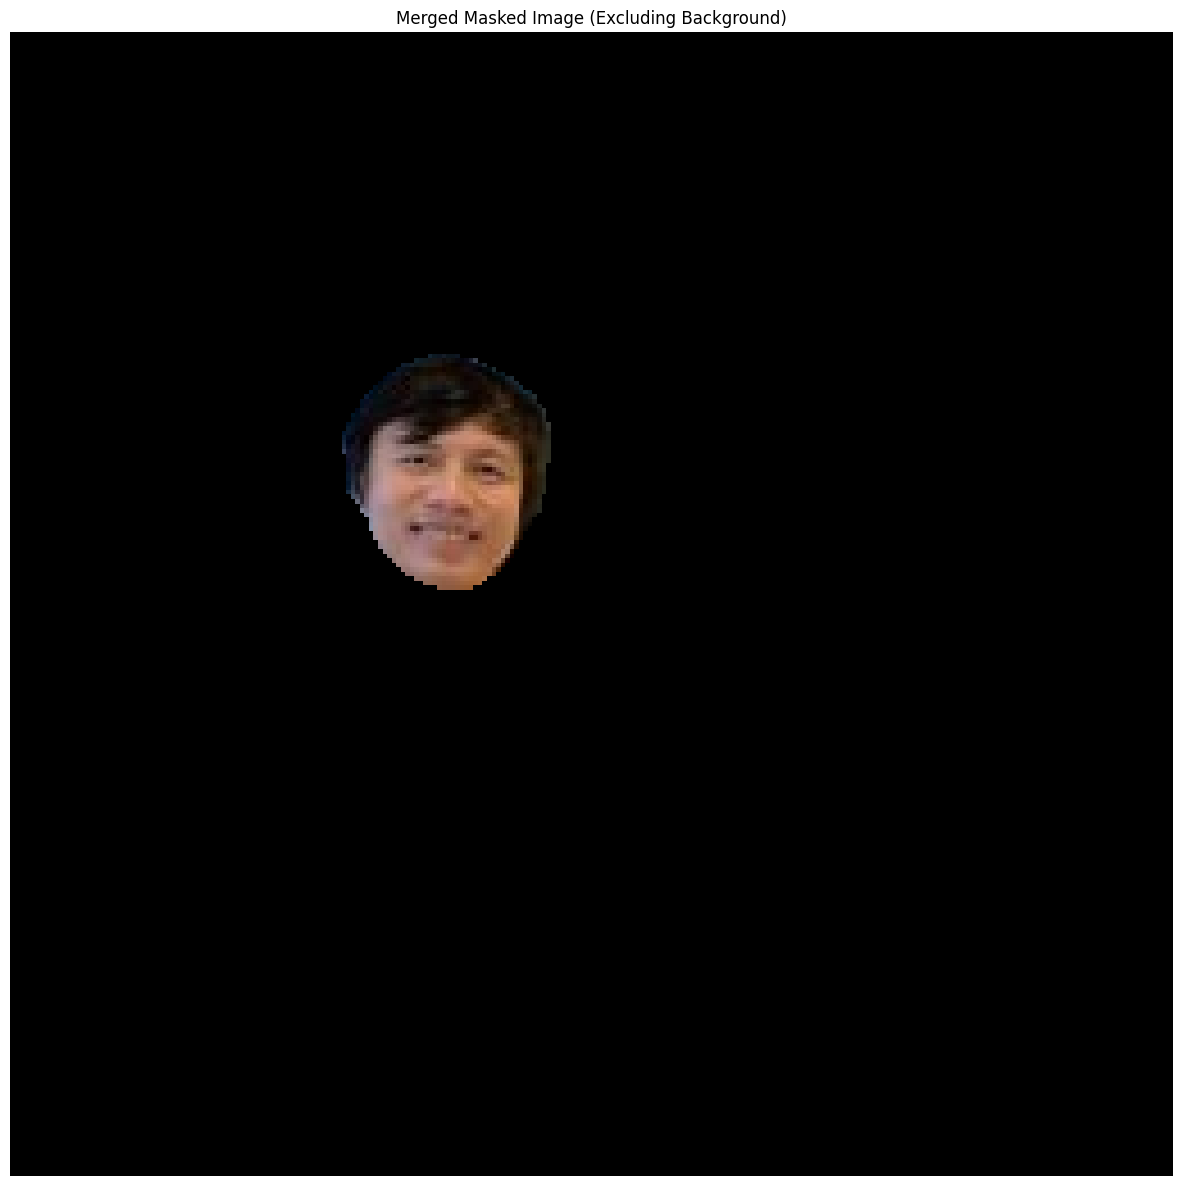

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Function to create a binary mask
def create_binary_mask(seg_probs, class_idx, threshold=0.5):
    # Select the class of interest and create a binary mask
    seg_mask = seg_probs[:, class_idx, :, :]
    binary_mask = (seg_mask > threshold).float()  # Apply threshold to get binary mask
    return binary_mask

def apply_mask_to_image(image, binary_mask):
    # Ensure the binary mask is of the same shape as the image
    # Reshape the binary mask to match the image shape
    # Select the first face (index 0) and expand to match the color channels
    binary_mask = binary_mask[0].unsqueeze(0).expand(image.shape[1], -1, -1)
    binary_mask = binary_mask.unsqueeze(0)  # Add the batch dimension back

    masked_image = image * binary_mask
    return masked_image

# Extract the segmentation probabilities
seg_logits = faces['seg']['logits']
seg_probs = seg_logits.softmax(dim=1)  # nfaces x nclasses x h x w

# Get the number of classes and labels from pretrain_settings
conf_name = face_parser.conf_name  # e.g., 'lapa/448' or 'celebm/448'
label_names = facer.face_parsing.farl.pretrain_settings[conf_name]['label_names']  # Correctly get label names

# Step 1: Apply binary mask for each class and combine them (skip 'background')
merged_mask = torch.zeros_like(seg_probs[:, 0, :, :])  # Create an empty mask for merging

masked_images = []
for i, label in enumerate(label_names):
    # Skip the 'background' class
    if label == 'background':
        continue

    # Step 1a: Create a binary mask for the class
    binary_mask = create_binary_mask(seg_probs, i)

    # Step 1b: Add the binary mask to the merged mask
    merged_mask = torch.maximum(merged_mask, binary_mask)  # Add the mask using maximum (to handle overlapping)

    # Step 1c: Apply the binary mask to the image (assume BCHW format)
    masked_image = apply_mask_to_image(image, binary_mask)
    masked_image_rgb = masked_image.squeeze(0).permute(1, 2, 0).cpu().numpy().astype(np.uint8)  # HWC format

    # Add the masked image to the list of masked images
    masked_images.append(masked_image_rgb)

# Step 2: Apply the merged mask to the image to get the final combined output
final_masked_image = apply_mask_to_image(image, merged_mask)

# Convert the final masked image to HWC format for display
final_masked_image_rgb = final_masked_image.squeeze(0).permute(1, 2, 0).cpu().numpy().astype(np.uint8)

# Step 3: Display the original image, individual masked images, and the final combined mask
plt.figure(figsize=(15, 15))

plt.imshow(final_masked_image_rgb)
plt.title("Merged Masked Image (Excluding Background)")
plt.axis('off')

plt.show()  # Ensure the plot is displayed


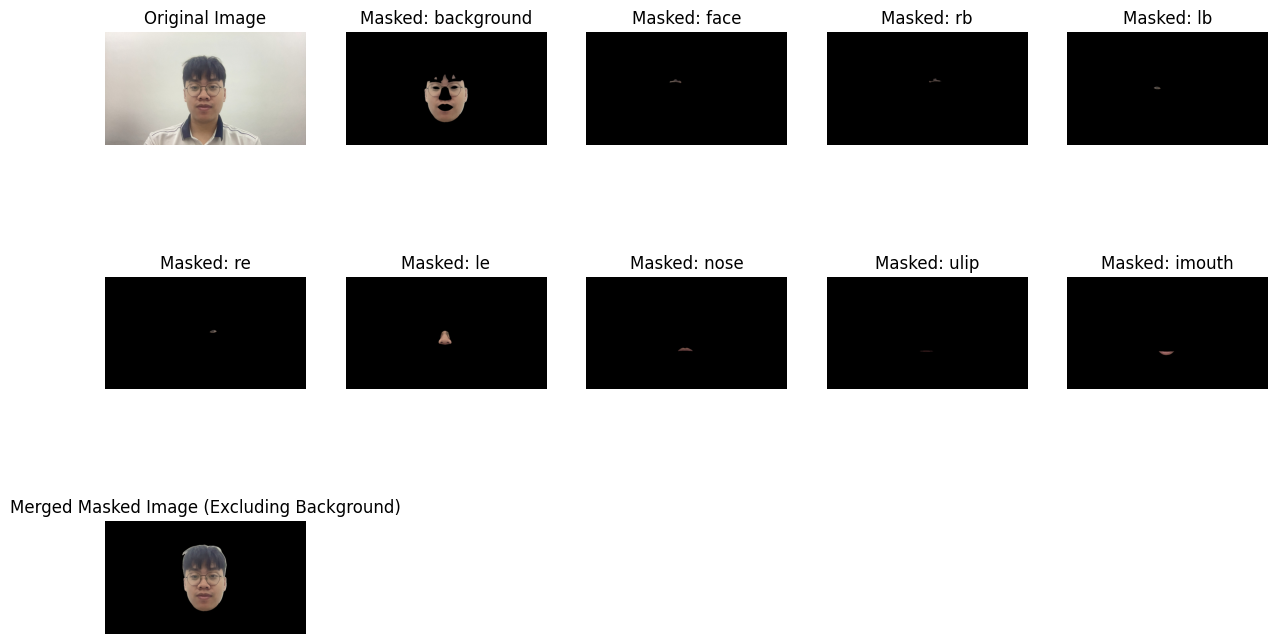

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import facer

def process_and_display_face_segmentation(image_path, model_name='retinaface/mobilenet',
                                          parser_name='farl/lapa/448', threshold=0.5,
                                          device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Process an image to perform face detection, segmentation, and display the results.

    Parameters:
    - image_path (str): Path to the image to process.
    - model_name (str): Name of the face detection model.
    - parser_name (str): Name of the face parsing model.
    - threshold (float): Threshold for binary mask creation.
    - device (str): Device for model execution ('cuda' or 'cpu').
    """

    # Load the image and convert to BCHW format
    image = facer.hwc2bchw(facer.read_hwc(image_path)).to(device=device)

    # Load the face detector model
    face_detector = facer.face_detector(model_name, device=device)

    # Detect faces
    with torch.inference_mode():
        faces = face_detector(image)

    # Load the face parser model
    face_parser = facer.face_parser(parser_name, device=device)

    # Parse faces for segmentation
    with torch.inference_mode():
        faces = face_parser(image, faces)

    # Extract segmentation logits and probabilities
    seg_logits = faces['seg']['logits']
    seg_probs = seg_logits.softmax(dim=1)  # nfaces x nclasses x h x w

    # Get the number of classes and label names
    conf_name = face_parser.conf_name  # e.g., 'lapa/448' or 'celebm/448'
    label_names = facer.face_parsing.farl.pretrain_settings[conf_name]['label_names']

    # Create a function to create a binary mask for each class
    def create_binary_mask(seg_probs, class_idx, threshold=0.5):
        seg_mask = seg_probs[:, class_idx, :, :]
        binary_mask = (seg_mask > threshold).float()
        return binary_mask

    # Create a function to apply the binary mask to the image
    def apply_mask_to_image(image, binary_mask):
        binary_mask = binary_mask[0].unsqueeze(0).expand(image.shape[1], -1, -1)
        binary_mask = binary_mask.unsqueeze(0)  # Add batch dimension back
        masked_image = image * binary_mask
        return masked_image

    # Process segmentation and apply masks
    masked_images = []
    merged_mask = torch.zeros_like(seg_probs[:, 0, :, :])  # Initialize merged mask

    for i, label in enumerate(label_names):
        if label == 'background':  # Skip background class
            continue

        # Create binary mask for the class
        binary_mask = create_binary_mask(seg_probs, i, threshold)

        # Merge the binary mask into the final merged mask
        merged_mask = torch.maximum(merged_mask, binary_mask)

        # Apply the binary mask to the image and store the masked image
        masked_image = apply_mask_to_image(image, binary_mask)
        masked_image_rgb = masked_image.squeeze(0).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
        masked_images.append(masked_image_rgb)

    # Apply the final merged mask to the image
    final_masked_image = apply_mask_to_image(image, merged_mask)
    final_masked_image_rgb = final_masked_image.squeeze(0).permute(1, 2, 0).cpu().numpy().astype(np.uint8)

    # Plot the results
    n_images = len(masked_images)
    total_images = n_images + 2  # Including original and final masked image
    cols = 5
    rows = (total_images + cols - 1) // cols  # Ensure enough rows to fit all images

    plt.figure(figsize=(15, rows * 3))

    # Display the original image
    image_rgb = image.squeeze(0).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
    plt.subplot(rows, cols, 1)
    plt.imshow(image_rgb)
    plt.title("Original Image")
    plt.axis('off')

    # Display individual masked images
    for i, masked_image_rgb in enumerate(masked_images):
        plt.subplot(rows, cols, i + 2)
        plt.imshow(masked_image_rgb)
        plt.title(f"Masked: {label_names[i]}")
        plt.axis('off')

    # Display the final merged masked image
    plt.imshow(final_masked_image_rgb)
    plt.title("Merged Masked Image (Excluding Background)")
    plt.axis('off')

    plt.show()

# Example usage
process_and_display_face_segmentation('/content/lamnt_1.jpg')


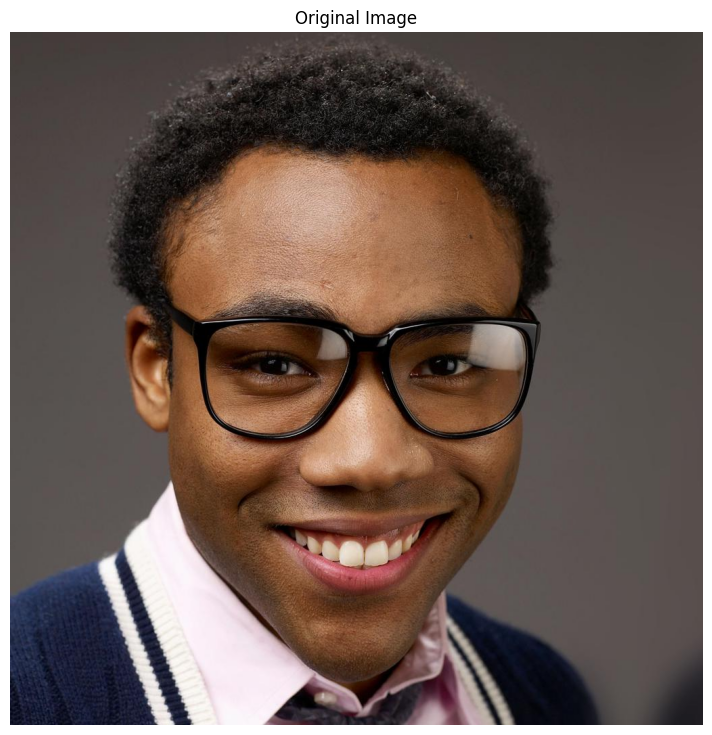

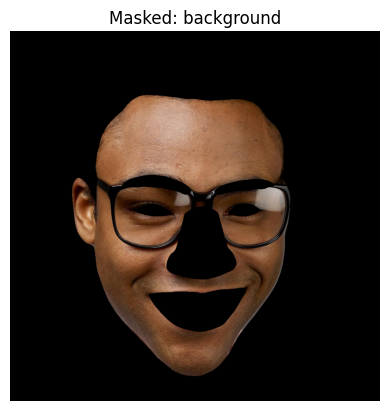

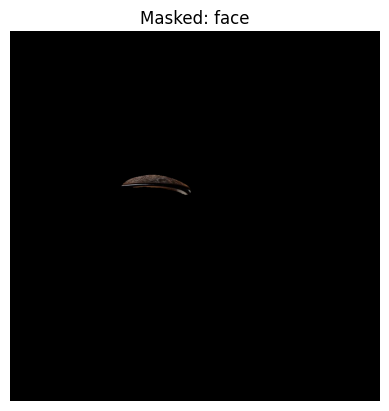

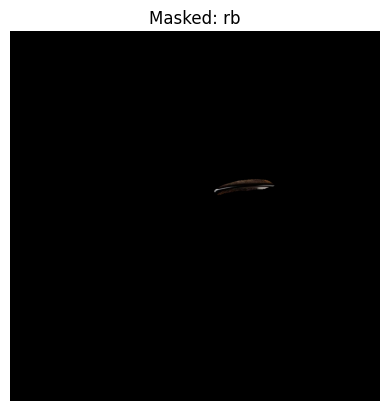

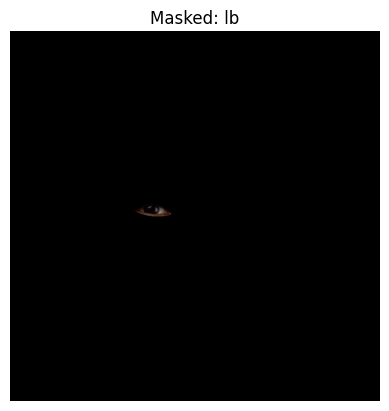

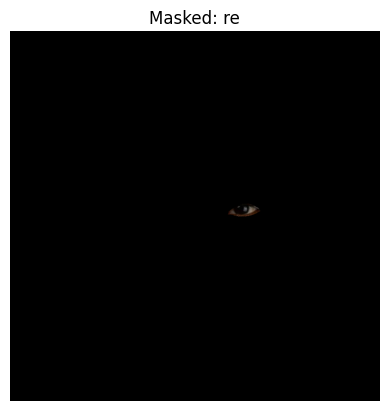

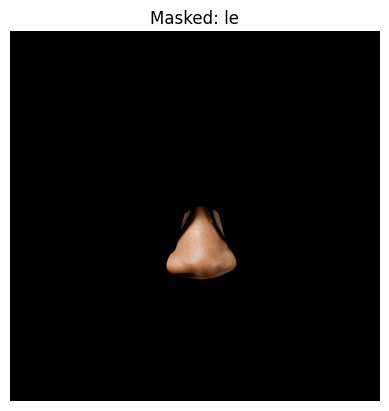

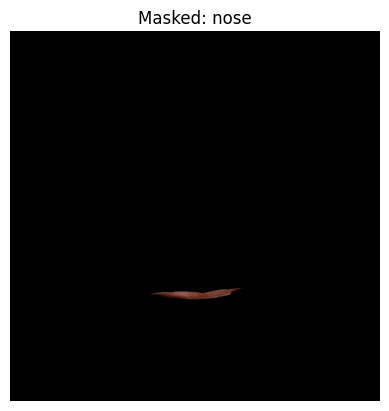

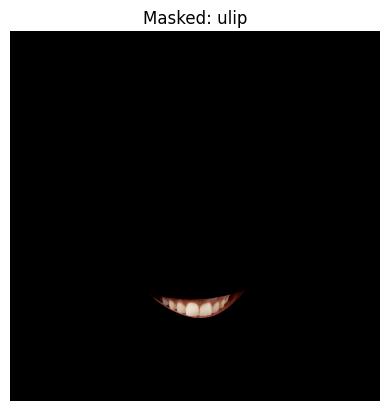

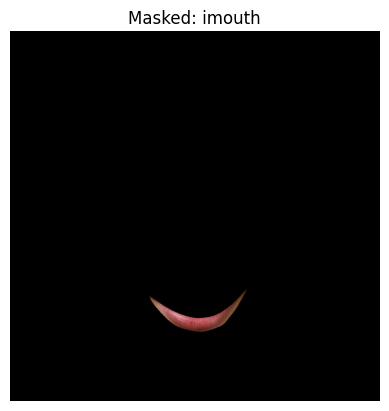

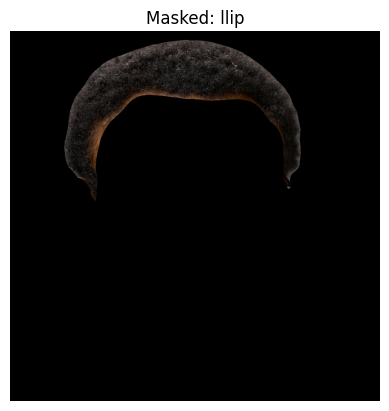

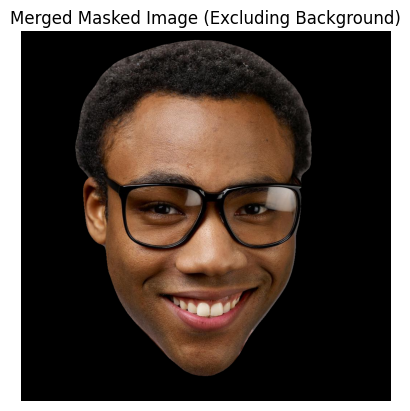

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import facer

def process_and_display_face_segmentation(image_path, model_name='retinaface/mobilenet',
                                          parser_name='farl/lapa/448', threshold=0.5,
                                          device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Process an image to perform face detection, segmentation, and display the results.

    Parameters:
    - image_path (str): Path to the image to process.
    - model_name (str): Name of the face detection model.
    - parser_name (str): Name of the face parsing model.
    - threshold (float): Threshold for binary mask creation.
    - device (str): Device for model execution ('cuda' or 'cpu').
    """

    # Load the image and convert to BCHW format
    image = facer.hwc2bchw(facer.read_hwc(image_path)).to(device=device)

    # Load the face detector model
    face_detector = facer.face_detector(model_name, device=device)

    # Detect faces
    with torch.inference_mode():
        faces = face_detector(image)

    # Load the face parser model
    face_parser = facer.face_parser(parser_name, device=device)

    # Parse faces for segmentation
    with torch.inference_mode():
        faces = face_parser(image, faces)

    # Extract segmentation logits and probabilities
    seg_logits = faces['seg']['logits']
    seg_probs = seg_logits.softmax(dim=1)  # nfaces x nclasses x h x w

    # Get the number of classes and label names
    conf_name = face_parser.conf_name  # e.g., 'lapa/448' or 'celebm/448'
    label_names = facer.face_parsing.farl.pretrain_settings[conf_name]['label_names']

    # Create a function to create a binary mask for each class
    def create_binary_mask(seg_probs, class_idx, threshold=0.5):
        seg_mask = seg_probs[:, class_idx, :, :]
        binary_mask = (seg_mask > threshold).float()
        return binary_mask

    # Create a function to apply the binary mask to the image
    def apply_mask_to_image(image, binary_mask):
        binary_mask = binary_mask[0].unsqueeze(0).expand(image.shape[1], -1, -1)
        binary_mask = binary_mask.unsqueeze(0)  # Add batch dimension back
        masked_image = image * binary_mask
        return masked_image

    # Process segmentation and apply masks
    masked_images = []
    merged_mask = torch.zeros_like(seg_probs[:, 0, :, :])  # Initialize merged mask

    for i, label in enumerate(label_names):
        if label == 'background':  # Skip background class
            continue

        # Create binary mask for the class
        binary_mask = create_binary_mask(seg_probs, i, threshold)

        # Merge the binary mask into the final merged mask
        merged_mask = torch.maximum(merged_mask, binary_mask)

        # Apply the binary mask to the image and store the masked image
        masked_image = apply_mask_to_image(image, binary_mask)
        masked_image_rgb = masked_image.squeeze(0).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
        masked_images.append(masked_image_rgb)

    # Apply the final merged mask to the image
    final_masked_image = apply_mask_to_image(image, merged_mask)
    final_masked_image_rgb = final_masked_image.squeeze(0).permute(1, 2, 0).cpu().numpy().astype(np.uint8)

    # Plot the results
    n_images = len(masked_images)
    total_images = n_images + 2  # Including original and final masked image
    cols = 5
    rows = (total_images + cols - 1) // cols  # Ensure enough rows to fit all images

    plt.figure(figsize=(15, rows * 3))

    # Display the original image
    image_rgb = image.squeeze(0).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
    plt.imshow(image_rgb)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    # Display individual masked images
    for i, masked_image_rgb in enumerate(masked_images):
        plt.imshow(masked_image_rgb)
        plt.title(f"Masked: {label_names[i]}")
        plt.axis('off')
        plt.show()

    # Display the final merged masked image
    plt.imshow(final_masked_image_rgb)
    plt.title("Merged Masked Image (Excluding Background)")
    plt.axis('off')

    plt.show()

# Example usage
process_and_display_face_segmentation('/content/168.jpg')


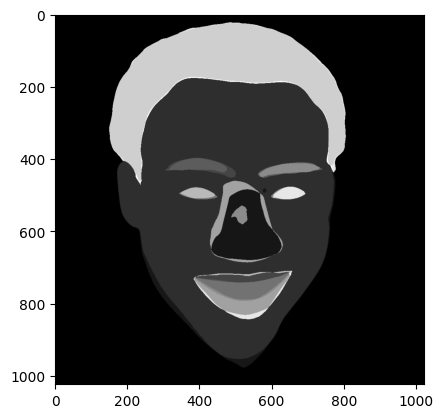

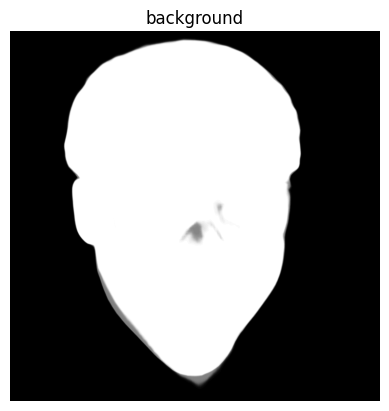

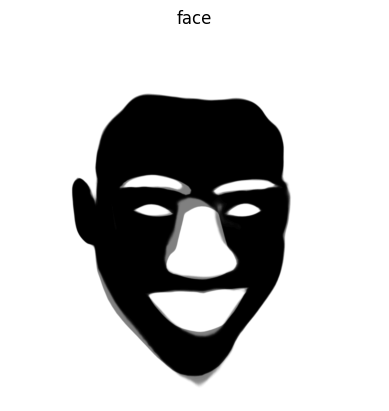

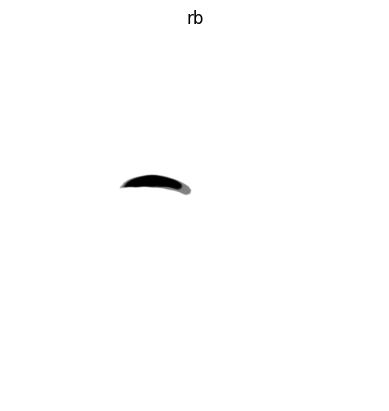

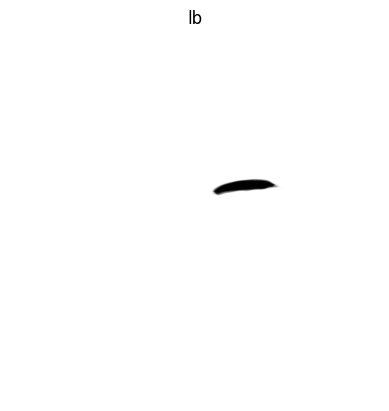

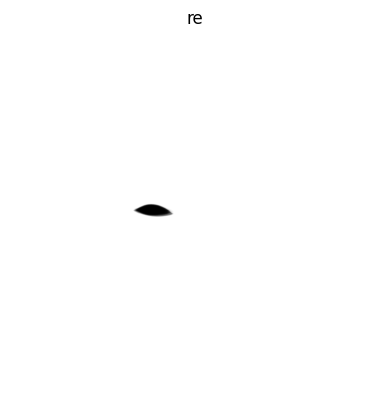

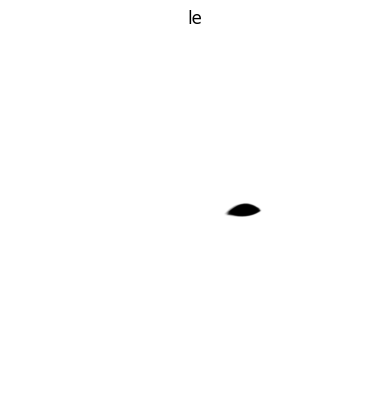

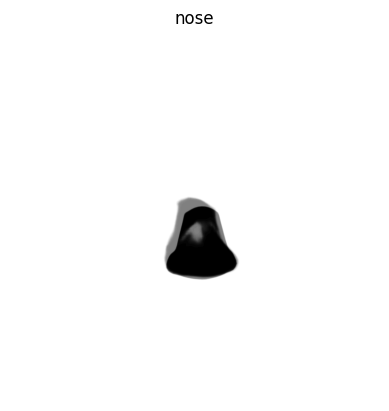

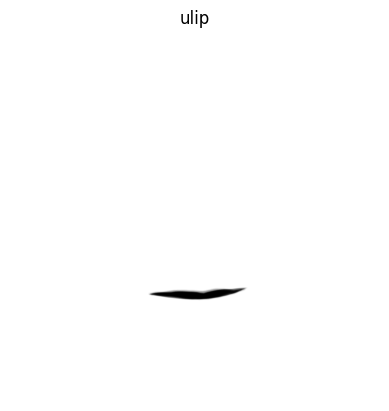

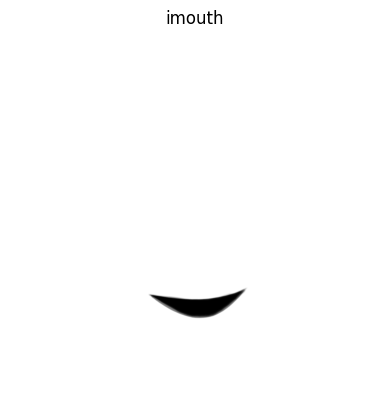

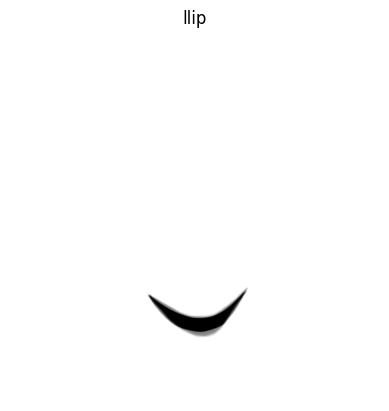

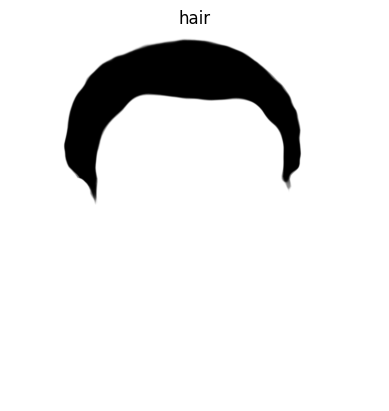

<Figure size 640x480 with 0 Axes>

In [ ]:
import cv2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

image = facer.hwc2bchw(facer.read_hwc('/content/168.jpg')).to(device=device)  # image: 1 x 3 x h x w

face_detector = facer.face_detector('retinaface/mobilenet', device=device)
with torch.inference_mode():
    faces = face_detector(image)

face_parser = facer.face_parser('farl/lapa/448', device=device) # optional "farl/celebm/448"

with torch.inference_mode():
    faces = face_parser(image, faces)

seg_logits = faces['seg']['logits']
seg_probs = seg_logits.softmax(dim=1)  # nfaces x nclasses x h x w
n_classes = seg_probs.size(1)
vis_seg_probs = seg_probs.argmax(dim=1).float()/n_classes*255
vis_img = vis_seg_probs.sum(0, keepdim=True)
facer.show_bhw(vis_img)
import torch
import matplotlib.pyplot as plt

# Extract the segmentation logits from the faces dictionary
seg_logits = faces['seg']['logits']
seg_probs = seg_logits.softmax(dim=1)  # nfaces x nclasses x h x w

# Get the number of classes and the label names
n_classes = seg_probs.size(1)
conf_name = face_parser.conf_name  # e.g., 'lapa/448' or 'celebm/448'
label_names = facer.face_parsing.farl.pretrain_settings[conf_name]['label_names']



# Now proceed with the rest of the code
seg_logits = faces['seg']['logits']
seg_probs = seg_logits.softmax(dim=1)  # nfaces x nclasses x h x w

# Get the number of classes
n_classes = seg_probs.size(1)
n_images = len(label_names)
cols = 5  # Number of columns in the grid (adjust as needed)
rows = (n_images + cols - 1) // cols

for i, label in enumerate(label_names):
    # Get the segmentation mask for the class
    seg_mask = seg_probs[:, i, :, :].sum(0, keepdim=True)  # Sum over faces
    seg_mask = seg_mask.float() / n_classes * 255  # Normalize for display

    # Show the mask using facer.show_bhw
    # facer.show_bhw(seg_mask)

    seg_mask_np = seg_mask.squeeze().cpu().numpy().astype('uint8')
    cv2.bitwise_not(seg_mask_np, seg_mask_np)
    plt.imshow(seg_mask_np, cmap='gray')
    plt.title(f'{label}')
    plt.axis('off')
    plt.show()

plt.tight_layout()
plt.show()